In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# --- read data --- 

path = '/scratch/pchen25/clim680_dataset/MidMiocene/'
file_Pi = 'Mio_Pi/B.MMIOx2_C5_280_WISOon.cam.clim_1900_1999.nc'
file_Mio = 'Mio_Mio/B.MMIOx2_C5_280_WISOon_aeroZonal.cam.clim_100_300.nc'

ds_Pi = xr.open_mfdataset(path+file_Pi)
ds_Mio = xr.open_mfdataset(path+file_Mio)

ds_Pi

<xarray.Dataset>
Dimensions:    (time: 1200, lat: 96, lon: 144, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon        (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time       (time) object 1900-02-01 00:00:00 ... 2000-01-01 00:00:00
Dimensions without coordinates: nbnd
Data variables:
    PRECC      (time, lat, lon) float32 dask.array<chunksize=(1200, 96, 144), meta=np.ndarray>
    PRECL      (time, lat, lon) float32 dask.array<chunksize=(1200, 96, 144), meta=np.ndarray>
    TS         (time, lat, lon) float32 dask.array<chunksize=(1200, 96, 144), meta=np.ndarray>
    time_bnds  (time, nbnd) object dask.array<chunksize=(1200, 2), meta=np.ndarray>
Attributes:
    Conventions:      CF-1.0
    source:           CAM
    case:             B.MMIOx2_C5_280_WISOon
    title:            UNSET
    logname:          pacosta
    host:             r8i0n31
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     /glade/scratch/pacosta/B.MMIOx2_C5_280_WISOon/run/B.MMI...
    topography_file:  /glade/work/pacosta/PaleoBC/heroldn/gx1vMIO/cami_bnd_to...
    history:          Thu Nov  2 18:37:20 2023: ncrcat ./B.MMIOx2_C5_280_WISO...
    NCO:              netCDF Operators version 5.1.4 (Homepage = http://nco.s...

In [3]:
# input LANDFRAC

path = '/scratch/pchen25/clim680_dataset/MidMiocene/atm/'
file_name = 'B.MMIOx2_C5_280_WISOon_ANN_concat.nc'
ds = xr.open_dataset(path+file_name)

var = 'LANDFRAC'
mask = ds[var][0,:,:]
data = ds['TS']

data, lons = add_cyclic_point(data, coord=ds['lon'])
mask, mask_lons = add_cyclic_point(mask, coord=ds['lon'])

In [4]:
# --- (var.): TS ---

var = 'TS'
ts_Pi = ds_Pi[var]
ts_Mio = ds_Mio[var][1200:2400,:,:]

# --- Anomaly ---
ts_Pi_gb = ts_Pi.groupby('time.month')
ts_Mio_gb = ts_Mio.groupby('time.month')
ts_Pi_anom = ts_Pi_gb - ts_Pi_gb.mean(dim='time')
ts_Mio_anom = ts_Mio_gb - ts_Mio_gb.mean(dim='time')

/home/pchen25/.conda/envs/clim_data/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 100 times more chunks
  return self.array[key]
/home/pchen25/.conda/envs/clim_data/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 100 times more chunks
  return self.array[key]


## EOF Analysis
(Oldeman et al. 2021): correlate the PC1 with ENSO indices to check which region is representative for ENSO variability

Domain: (25°S-25°N, 130°E-90°W) (Saji et al. 2006)

#### Reference:
Oldeman, A. M., Baatsen, M. L., von Der Heydt, A. S., Dijkstra, H. A., Tindall, J. C., Abe-Ouchi, A., ... & Williams, C. J. (2021). Reduced El Niño variability in the mid-Pliocene according to the PlioMIP2 ensemble. Climate of the Past Discussions, 2021, 1-35.

Saji, N. H., Xie, S. P., & Yamagata, T. (2006). Tropical Indian Ocean variability in the IPCC twentieth-century climate simulations. Journal of Climate, 19(17), 4397-4417.

In [5]:
# select domain

ts_Pi_TroPac = ts_Pi_anom.sel(lat=slice(-25,25),lon=slice(130,270))
ts_Mio_TroPac = ts_Mio_anom.sel(lat=slice(-25,25),lon=slice(130,270))

# --- Mio_Pi: DJF
shape1 = (100, 12, 26, 57)
TroPac_Pi_yr1 = np.random.randn(*shape1)

for yy in range(100):
    TroPac_Pi_yr1[yy,:,:,:] = ts_Pi_TroPac[yy*12:yy*12+12,:,:]

shape2 = (1, 99, 26, 57)
TroPac_Pi_djf = np.random.randn(*shape2)

for tt in range(99):
    TroPac_Pi_djf[0, tt,:,:] = (TroPac_Pi_yr1[tt,11,:,:] + TroPac_Pi_yr1[tt+1,0,:,:] + TroPac_Pi_yr1[tt+1,1,:,:])/3

TroPac_Pi_djf = np.squeeze(TroPac_Pi_djf, axis=0)


# --- Mio_Mio: DJF
TroPac_Mio_yr1 = np.random.randn(*shape1)

for yy in range(100):
    TroPac_Mio_yr1[yy,:,:,:] = ts_Mio_TroPac[yy*12:yy*12+12,:,:]

shape2 = (1, 99, 26, 57)
TroPac_Mio_djf = np.random.randn(*shape2)

for tt in range(99):
    TroPac_Mio_djf[0, tt,:,:] = (TroPac_Mio_yr1[tt,11,:,:] + TroPac_Mio_yr1[tt+1,0,:,:] + TroPac_Mio_yr1[tt+1,1,:,:])/3

TroPac_Mio_djf = np.squeeze(TroPac_Mio_djf, axis=0)

In [6]:
# Weighting of the data

coslat = np.cos(np.deg2rad(ts_Pi_TroPac.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
ts_Pi_wgt = TroPac_Pi_djf*wgts
ts_Mio_wgt = TroPac_Mio_djf*wgts

# Reshape from [lat,lon,time] to [time,space]
nx = len(ts_Pi_TroPac['lon'])
ny = len(ts_Pi_TroPac['lat'])
nt = 99

ts_Pi_X = np.reshape(ts_Pi_wgt, ((nt,ny*nx)))
ts_Mio_X = np.reshape(ts_Mio_wgt, ((nt,ny*nx)))

ts_Pi_X.shape

(99, 1482)

In [7]:
# --- Calculation of EOFs ---
# Calculate the Covariance Matrix

ts_Pi_C = np.cov(ts_Pi_X)
ts_Mio_C = np.cov(ts_Mio_X)

# Calculate the eigenvalues and vectors of the Covariance Matrix
from numpy import linalg as LA

eigenvalues_Pi, eigenvectors_Pi = LA.eig(ts_Pi_C)
eigenvalues_Mio, eigenvectors_Mio = LA.eig(ts_Mio_C)

In [8]:
idx_Pi = eigenvalues_Pi.argsort()[::-1]  # Sorts the indices of the matrix based on the magnitudes of the eigenvalues
eigenvalues_Pi = eigenvalues_Pi[idx_Pi]
eigenvectors_Pi = eigenvectors_Pi[:,idx_Pi]

In [9]:
PC_Pi = eigenvectors_Pi
PC_Mio = eigenvectors_Mio

EOF_Pi = np.dot(ts_Pi_X.T, PC_Pi)
EOF_Pi = EOF_Pi.reshape((ny,nx,nt)).T/wgts.squeeze()

EOF_Mio = np.dot(ts_Mio_X.T, PC_Mio)
EOF_Mio = EOF_Mio.reshape((ny,nx,nt)).T/wgts.squeeze()

/tmp/ipykernel_3092169/3632930953.py:7: UserWarning: The following kwargs were not used by contour: 'crs'
  panel = ax1[i].contourf(ts_Pi_TroPac['lon'], ts_Pi_TroPac['lat'], EOF_Pi[i,:,:].T, clevs,


''

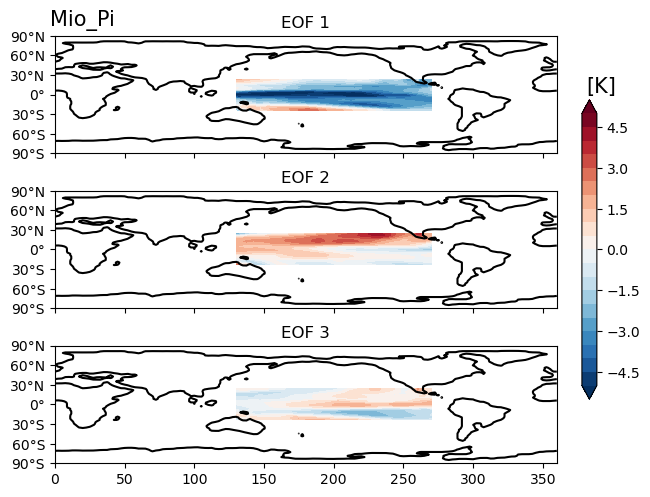

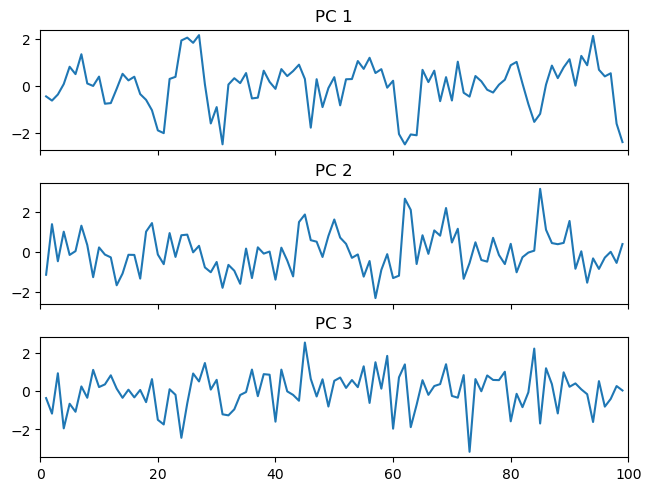

In [10]:
# Plot the first three EOFs (the ones with the most variance) - Mio_Pi

clevs = np.linspace(-5, 5, 21)

fig, ax1 = plt.subplots(nrows=3, ncols=1, layout="constrained", sharex='col')
for i in np.arange(3):
    panel = ax1[i].contourf(ts_Pi_TroPac['lon'], ts_Pi_TroPac['lat'], EOF_Pi[i,:,:].T, clevs, 
                            crs=ccrs.PlateCarree(),
                            cmap='RdBu_r', extend='both')
    ax1[i].set_title(f"EOF {i+1}")

    # Latitude labels
    ax1[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    ax1[i].yaxis.set_major_formatter(lat_formatter)
    
    ax1[i].contour(lons, ds['lat'], mask, [0.5,1.5],
                  colors='k', linewidths=1.5, zorder=3)
    
plt.figtext(0.93,0.83,'[K]',ha='center',fontsize=15)
plt.figtext(0.12,0.97,'Mio_Pi',ha='center',fontsize=15)
fig.colorbar(panel, ax=ax1, shrink=0.7) 


fig, ax1_time = plt.subplots(nrows=3, ncols=1, layout="constrained", sharex='col')
for i in np.arange(3):
    pcnorm = PC_Pi[:,i]/np.std(PC_Pi[:,i])
    panel = ax1_time[i].plot(np.arange(1,100),pcnorm)
    ax1_time[i].set_title(f"PC {i+1}")
    plt.xlim(0, 100)
;

/tmp/ipykernel_3092169/4047304113.py:7: UserWarning: The following kwargs were not used by contour: 'crs'
  panel = ax1[i].contourf(ts_Mio_TroPac['lon'], ts_Mio_TroPac['lat'], EOF_Mio[i,:,:].T, clevs,


''

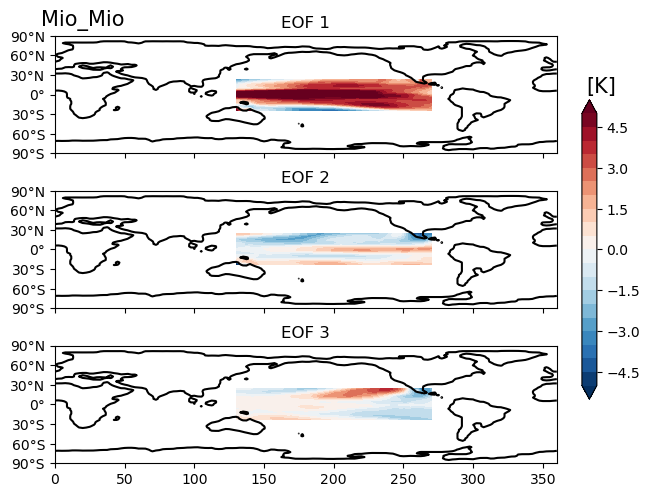

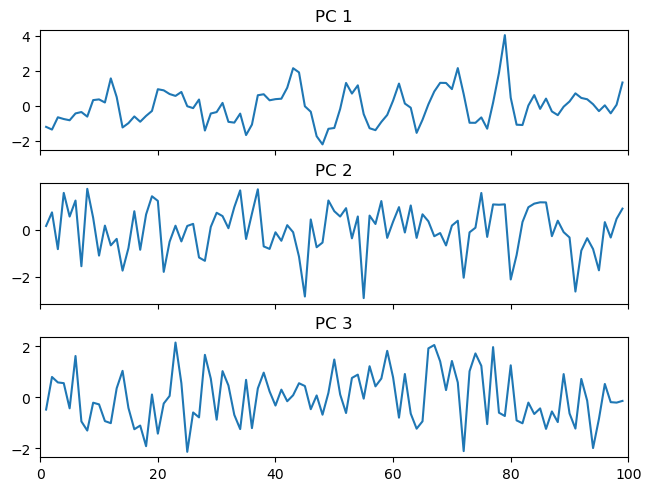

In [11]:
# Plot the first three EOFs (the ones with the most variance) - Mio_Mio

clevs = np.linspace(-5, 5, 21)

fig, ax1 = plt.subplots(nrows=3, ncols=1, layout="constrained", sharex='col')
for i in np.arange(3):
    panel = ax1[i].contourf(ts_Mio_TroPac['lon'], ts_Mio_TroPac['lat'], EOF_Mio[i,:,:].T, clevs, 
                            crs=ccrs.PlateCarree(),
                            cmap='RdBu_r', extend='both')
    ax1[i].set_title(f"EOF {i+1}")

    # Latitude labels
    ax1[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    ax1[i].yaxis.set_major_formatter(lat_formatter)
    
    ax1[i].contour(lons, ds['lat'], mask, [0.5,1.5],
                  colors='k', linewidths=1.5, zorder=3)
    
plt.figtext(0.93,0.83,'[K]',ha='center',fontsize=15)
plt.figtext(0.12,0.97,'Mio_Mio',ha='center',fontsize=15)
fig.colorbar(panel, ax=ax1, shrink=0.7) 


fig, ax1_time = plt.subplots(nrows=3, ncols=1, layout="constrained", sharex='col')
for i in np.arange(3):
    pcnorm = PC_Mio[:,i]/np.std(PC_Mio[:,i])
    panel = ax1_time[i].plot(np.arange(1,100),pcnorm)
    ax1_time[i].set_title(f"PC {i+1}")
    plt.xlim(0, 100)
;

## ENSO index

### 1. Nino3.4
Domain: (5°S-5°N, 170°W-120°W)

In [12]:
lon_min = 190
lon_max = 240

ts_Nino34_Pi = ts_Pi_anom.sel(lat=slice(-5, 5), lon=slice(lon_min, lon_max))
ts_Nino34_Mio = ts_Mio_anom.sel(lat=slice(-5, 5), lon=slice(lon_min, lon_max))

In [13]:
# --- Mio_Pi: DJF
weights = np.cos(np.deg2rad(ts_Nino34_Pi.lat))
Nino34_Pi = ts_Nino34_Pi.weighted(weights).mean(dim=['lon','lat'])

shape1 = (100, 12)
Nino34_Pi_yr1 = np.random.randn(*shape1)

for yy in range(100):
    Nino34_Pi_yr1[yy,:] = Nino34_Pi[yy*12:yy*12+12]

shape2 = (1, 99)
Nino34_Pi_djf = np.random.randn(*shape2)

for tt in range(99):
    Nino34_Pi_djf[0, tt] = (Nino34_Pi_yr1[tt,11] + Nino34_Pi_yr1[tt+1,0] + Nino34_Pi_yr1[tt+1,1])/3

In [14]:
# --- Mio_Mio: DJF
weights = np.cos(np.deg2rad(ts_Nino34_Mio.lat))
Nino34_Mio = ts_Nino34_Mio.weighted(weights).mean(dim=['lon','lat'])

shape1 = (100, 12)
Nino34_Mio_yr1 = np.random.randn(*shape1)

for yy in range(100):
    Nino34_Mio_yr1[yy,:] = Nino34_Mio[yy*12:yy*12+12]

shape2 = (1, 99)
Nino34_Mio_djf = np.random.randn(*shape2)

for tt in range(99):
    Nino34_Mio_djf[0, tt] = (Nino34_Mio_yr1[tt,11] + Nino34_Mio_yr1[tt+1,0] + Nino34_Mio_yr1[tt+1,1])/3

### 2. Nino4
Domain: (5°S-5°N, 160°E-150°W)

In [15]:
lon_min = 160
lon_max = 210

ts_Nino4_Pi = ts_Pi_anom.sel(lat=slice(-5, 5), lon=slice(lon_min, lon_max))
ts_Nino4_Mio = ts_Mio_anom.sel(lat=slice(-5, 5), lon=slice(lon_min, lon_max))

In [16]:
# --- Mio_Pi: DJF
weights = np.cos(np.deg2rad(ts_Nino4_Pi.lat))
Nino4_Pi = ts_Nino4_Pi.weighted(weights).mean(dim=['lon','lat'])

shape1 = (100, 12)
Nino4_Pi_yr1 = np.random.randn(*shape1)

for yy in range(100):
    Nino4_Pi_yr1[yy,:] = Nino4_Pi[yy*12:yy*12+12]

shape2 = (1, 99)
Nino4_Pi_djf = np.random.randn(*shape2)

for tt in range(99):
    Nino4_Pi_djf[0, tt] = (Nino4_Pi_yr1[tt,11] + Nino4_Pi_yr1[tt+1,0] + Nino4_Pi_yr1[tt+1,1])/3

In [17]:
# --- Mio_Mio: DJF
weights = np.cos(np.deg2rad(ts_Nino4_Mio.lat))
Nino4_Mio = ts_Nino4_Mio.weighted(weights).mean(dim=['lon','lat'])

shape1 = (100, 12)
Nino4_Mio_yr1 = np.random.randn(*shape1)

for yy in range(100):
    Nino4_Mio_yr1[yy,:] = Nino4_Mio[yy*12:yy*12+12]

shape2 = (1, 99)
Nino4_Mio_djf = np.random.randn(*shape2)

for tt in range(99):
    Nino4_Mio_djf[0, tt] = (Nino4_Mio_yr1[tt,11] + Nino4_Mio_yr1[tt+1,0] + Nino4_Mio_yr1[tt+1,1])/3

### 3. Nino3
Domain: (5°S-5°N, 150°W-90°W)

In [18]:
lon_min = 210
lon_max = 270

ts_Nino3_Pi = ts_Pi_anom.sel(lat=slice(-5, 5), lon=slice(lon_min, lon_max))
ts_Nino3_Mio = ts_Mio_anom.sel(lat=slice(-5, 5), lon=slice(lon_min, lon_max))

In [19]:
# --- Mio_Pi: DJF
weights = np.cos(np.deg2rad(ts_Nino3_Pi.lat))
Nino3_Pi = ts_Nino3_Pi.weighted(weights).mean(dim=['lon','lat'])

shape1 = (100, 12)
Nino3_Pi_yr1 = np.random.randn(*shape1)

for yy in range(100):
    Nino3_Pi_yr1[yy,:] = Nino3_Pi[yy*12:yy*12+12]

shape2 = (1, 99)
Nino3_Pi_djf = np.random.randn(*shape2)

for tt in range(99):
    Nino3_Pi_djf[0, tt] = (Nino3_Pi_yr1[tt,11] + Nino3_Pi_yr1[tt+1,0] + Nino3_Pi_yr1[tt+1,1])/3

In [20]:
# --- Mio_Mio: DJF
weights = np.cos(np.deg2rad(ts_Nino3_Mio.lat))
Nino3_Mio = ts_Nino3_Mio.weighted(weights).mean(dim=['lon','lat'])

shape1 = (100, 12)
Nino3_Mio_yr1 = np.random.randn(*shape1)

for yy in range(100):
    Nino3_Mio_yr1[yy,:] = Nino3_Mio[yy*12:yy*12+12]

shape2 = (1, 99)
Nino3_Mio_djf = np.random.randn(*shape2)

for tt in range(99):
    Nino3_Mio_djf[0, tt] = (Nino3_Mio_yr1[tt,11] + Nino3_Mio_yr1[tt+1,0] + Nino3_Mio_yr1[tt+1,1])/3

### Correlation: PC vs ENSO indices

In [21]:
# --- Correlation: Mio_Pi ---
# PC1

R_Nino4_Pi = np.corrcoef(Nino4_Pi_djf, PC_Pi[:,0]/np.std(PC_Pi[:,0]))
R_Nino34_Pi = np.corrcoef(Nino34_Pi_djf, PC_Pi[:,0]/np.std(PC_Pi[:,0]))
R_Nino3_Pi = np.corrcoef(Nino3_Pi_djf, PC_Pi[:,0]/np.std(PC_Pi[:,0]))

corr_Nino4_Pi = R_Nino4_Pi[0,1]
corr_Nino34_Pi = R_Nino34_Pi[0,1]
corr_Nino3_Pi = R_Nino3_Pi[0,1]

print('Mio_Pi:')
print('Correlation (Nino4 & PC1): ', corr_Nino4_Pi)
print('Correlation (Nino34 & PC1): ', corr_Nino34_Pi)
print('Correlation (Nino3 & PC1): ', corr_Nino3_Pi)

# PC2

R_Nino4_Pi = np.corrcoef(Nino4_Pi_djf, PC_Pi[:,1]/np.std(PC_Pi[:,1]))
R_Nino34_Pi = np.corrcoef(Nino34_Pi_djf, PC_Pi[:,1]/np.std(PC_Pi[:,1]))
R_Nino3_Pi = np.corrcoef(Nino3_Pi_djf, PC_Pi[:,1]/np.std(PC_Pi[:,1]))

corr_Nino4_Pi = R_Nino4_Pi[0,1]
corr_Nino34_Pi = R_Nino34_Pi[0,1]
corr_Nino3_Pi = R_Nino3_Pi[0,1]

print('Correlation (Nino4 & PC2): ', corr_Nino4_Pi)
print('Correlation (Nino34 & PC2): ', corr_Nino34_Pi)
print('Correlation (Nino3 & PC2): ', corr_Nino3_Pi)

Mio_Pi:
Correlation (Nino4 & PC1):  -0.9365878550784119
Correlation (Nino34 & PC1):  -0.918756964882145
Correlation (Nino3 & PC1):  -0.8661335976616584
Correlation (Nino4 & PC2):  0.10992872642388771
Correlation (Nino34 & PC2):  -0.044520740637621944
Correlation (Nino3 & PC2):  -0.1331833881829154


In [22]:
# --- Correlation: Mio_Mio ---
# PC1

R_Nino4_Mio = np.corrcoef(Nino4_Mio_djf, PC_Mio[:,0]/np.std(PC_Mio[:,0]))
R_Nino34_Mio = np.corrcoef(Nino34_Mio_djf, PC_Mio[:,0]/np.std(PC_Mio[:,0]))
R_Nino3_Mio = np.corrcoef(Nino3_Mio_djf, PC_Mio[:,0]/np.std(PC_Mio[:,0]))

corr_Nino4_Mio = R_Nino4_Mio[0,1]
corr_Nino34_Mio = R_Nino34_Mio[0,1]
corr_Nino3_Mio = R_Nino3_Mio[0,1]

print('Mio_Mio:')
print('Correlation (Nino4 & PC1): ', corr_Nino4_Mio)
print('Correlation (Nino34 & PC1): ', corr_Nino34_Mio)
print('Correlation (Nino3 & PC1): ', corr_Nino3_Mio)

# PC2

R_Nino4_Mio = np.corrcoef(Nino4_Mio_djf, PC_Mio[:,1]/np.std(PC_Mio[:,1]))
R_Nino34_Mio = np.corrcoef(Nino34_Mio_djf, PC_Mio[:,1]/np.std(PC_Mio[:,1]))
R_Nino3_Mio = np.corrcoef(Nino3_Mio_djf, PC_Mio[:,1]/np.std(PC_Mio[:,1]))

corr_Nino4_Mio = R_Nino4_Mio[0,1]
corr_Nino34_Mio = R_Nino34_Mio[0,1]
corr_Nino3_Mio = R_Nino3_Mio[0,1]

print('Correlation (Nino4 & PC2): ', corr_Nino4_Mio)
print('Correlation (Nino34 & PC2): ', corr_Nino34_Mio)
print('Correlation (Nino3 & PC2): ', corr_Nino3_Mio)

Mio_Mio:
Correlation (Nino4 & PC1):  0.9648163038057874
Correlation (Nino34 & PC1):  0.9415367233279341
Correlation (Nino3 & PC1):  0.8761428751351985
Correlation (Nino4 & PC2):  0.08249128418894384
Correlation (Nino34 & PC2):  0.18462524817859138
Correlation (Nino3 & PC2):  0.24673326280133012


---
I selected Nino4 as the ENSO index

In [23]:
Nino4_Pi_djf = np.squeeze(Nino4_Pi_djf, axis=0)
Nino4_Pi_djf2 = xr.DataArray(data=Nino4_Pi_djf,
                             dims=['time'],
                             coords=[np.arange(1,100)])

Nino4_Mio_djf = np.squeeze(Nino4_Mio_djf, axis=0)
Nino4_Mio_djf2 = xr.DataArray(data=Nino4_Mio_djf,
                              dims=['time'],
                              coords=[np.arange(1,100)])

Mio_Pi Nino4 std:  0.5208236421609446
Mio_Mio Nino4 std:  0.6119684953103017


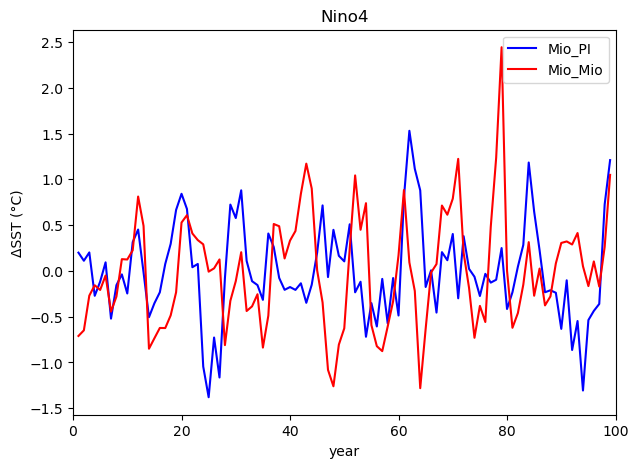

In [25]:
print('Mio_Pi Nino4 std: ', np.std(Nino4_Pi_djf2.values))
print('Mio_Mio Nino4 std: ', np.std(Nino4_Mio_djf2.values))

# Create the plot
fig, ax1 = plt.subplots()
fig.set_size_inches(7,5)

ax1.set_xlabel('year')
ax1.set_ylabel('ΔSST (°C)')
ax1.plot(np.arange(1,100,1), Nino4_Pi_djf2, color='b')
ax1.plot(np.arange(1,100,1), Nino4_Mio_djf2, color='r')

plt.title('Nino4')
plt.xlim(0, 100)
plt.legend(['Mio_PI', 'Mio_Mio'])

# Show the plot
plt.show()

### Mio_Pi (Miocene simulation with Pre-industrial aerosols)

El Nino:  4
Neutral:  91
La Nina:  4


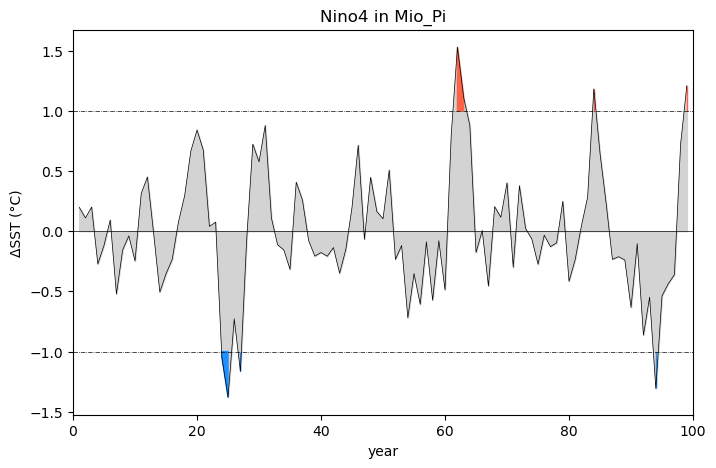

In [50]:
# --- Mio_PI: (Nino4 index) ---
elnino_Pi = Nino4_Pi_djf2.where(Nino4_Pi_djf2>=1)
lanina_Pi = Nino4_Pi_djf2.where(Nino4_Pi_djf2<=-1)
neutral_Pi = Nino4_Pi_djf2.where(np.logical_and(Nino4_Pi_djf2>-1, Nino4_Pi_djf2<1))

print('El Nino: ', elnino_Pi.count(dim='time').values)
print('Neutral: ', neutral_Pi.count(dim='time').values)
print('La Nina: ', lanina_Pi.count(dim='time').values)

counts_Pi=[elnino_Pi.count(dim='time').values,
        lanina_Pi.count(dim='time').values,
        neutral_Pi.count(dim='time').values]

# Create the plot
fig, ax2 = plt.subplots()
fig.set_size_inches(8,5)

ax2.set_xlabel('year')
ax2.set_ylabel('ΔSST (°C)')
ax2.plot(np.arange(1,100,1), Nino4_Pi_djf2, color='k', linewidth=0.5)
plt.fill_between(np.arange(1,100,1), Nino4_Pi_djf2, color='lightgrey')
plt.fill_between(np.arange(1,100,1), elnino_Pi, y2=1.0, color='tomato')
plt.fill_between(np.arange(1,100,1), lanina_Pi, y2=-1.0, color='dodgerblue')

plt.title('Nino4 in Mio_Pi')
plt.xlim(0, 100)

plt.axhline(0, color='black', linewidth=0.5)
plt.axhline(1, color='black', linewidth=0.5, linestyle='-.')
plt.axhline(-1, color='black', linewidth=0.5, linestyle='-.')

# Show the plot
plt.show()

In [33]:
# --- (var.): precipitation ---

precc_Pi = ds_Pi['PRECC']
precl_Pi = ds_Pi['PRECL']
prec_Pi = (precc_Pi + precl_Pi)*1000*86400

prec_Pi_clim = prec_Pi.groupby('time.month').mean()
prec_Pi_ano = prec_Pi.groupby('time.month')-prec_Pi_clim

# --- Mio_Pi: DJF
globe_shape1 = (100, 12, 96, 144)
prec_Pi_yr1 = np.random.randn(*globe_shape1)

for yy in range(100):
    prec_Pi_yr1[yy,:,:,:] = prec_Pi_ano[yy*12:yy*12+12,:,:]

globe_shape2 = (99, 96, 144)
prec_Pi_djf = np.random.randn(*globe_shape2)

for tt in range(99):
    prec_Pi_djf[tt,:,:] = (prec_Pi_yr1[tt,11,:,:] + prec_Pi_yr1[tt+1,0,:,:] + prec_Pi_yr1[tt+1,1,:,:])/3

prec_Pi_djf2 = xr.DataArray(data=prec_Pi_djf,
                            dims=['time','lat','lon'],
                            coords=[np.arange(1,100), prec_Pi_ano['lat'], prec_Pi_ano['lon']])

/home/pchen25/.conda/envs/clim_data/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 100 times more chunks
  return self.array[key]


In [36]:
elnino_prec_Pi = prec_Pi_djf2.sel(time=elnino_Pi.dropna(dim='time')['time']).mean(dim='time')
lanina_prec_Pi = prec_Pi_djf2.sel(time=lanina_Pi.dropna(dim='time')['time']).mean(dim='time')
neutral_prec_Pi = prec_Pi_djf2.sel(time=neutral_Pi.dropna(dim='time')['time']).mean(dim='time')

comp_precip_Pi = [elnino_prec_Pi,lanina_prec_Pi,neutral_prec_Pi]

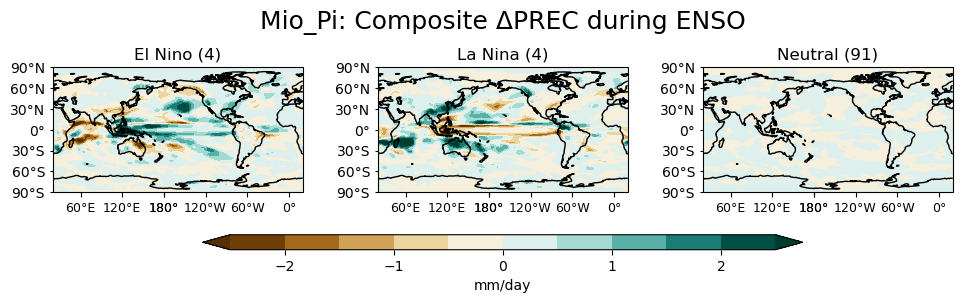

In [38]:
labels=['El Nino','La Nina', 'Neutral']
clevs = np.linspace(-2.5, 2.5, 11)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs_Pi = plt.subplots(nrows=1,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=200)},
                        figsize=(10, 15))

#flatten axs into a 1-D array (just 3 rows)
axs_Pi = axs_Pi.flatten()

#Loop over all of the composites and plot
for i,enso in enumerate(comp_precip_Pi):

        # Select the season
        data = comp_precip_Pi[i]

        # Add the cyclic point
        data,lons = add_cyclic_point(data, coord=comp_precip_Pi[i]['lon'])

        # Contour plot
        cs=axs_Pi[i].contourf(lons,comp_precip_Pi[i]['lat'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='BrBG',extend='both')

       # Longitude labels
        axs_Pi[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs_Pi[i].xaxis.set_major_formatter(lon_formatter)
        axs_Pi[i].tick_params(axis='y', size=2)             # set xtick parameters
        for xlabel in axs_Pi[i].get_xticklabels():          # set xticks_label
            xlabel.set_fontsize(9)     

        # Latitude labels
        axs_Pi[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs_Pi[i].yaxis.set_major_formatter(lat_formatter)

        
        # Title each subplot with the name of the season
        axs_Pi[i].set_title(labels[i]+' ('+str(counts_Pi[i])+')')

        # Draw the coastines for each subplot
        axs_Pi[i].coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.65, left=0.05, right=0.95, wspace=0.3, hspace=0.1)

# Add a colorbar
cax  = fig.add_axes([0.2, 0.37, 0.6, 0.01])    # set the [x0, y0, width, height] of the colorbar
CB   = plt.colorbar(cs, cax = cax, orientation='horizontal', label='mm/day')

# Add a big title at the top
plt.suptitle('Mio_Pi: Composite ΔPREC during ENSO', y=0.53, fontsize=18) ;

### Mio_Mio (Miocene simulation with Miocene aerosols)

El Nino:  6
Neutral:  90
La Nina:  3


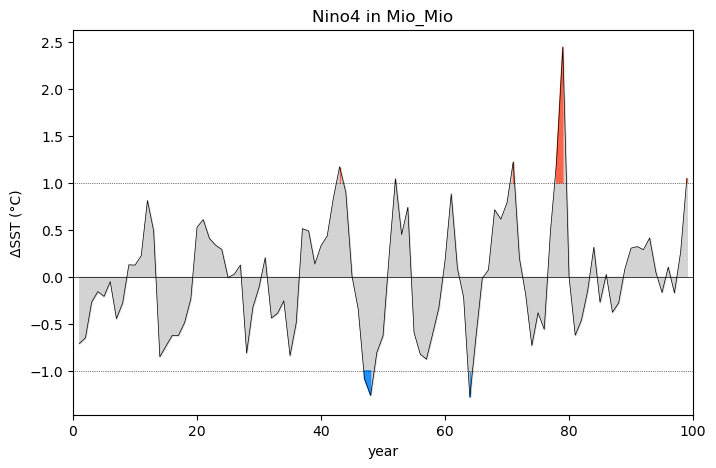

In [49]:
# --- Mio_Mio: (Nino4 index) ---

elnino_Mio = Nino4_Mio_djf2.where(Nino4_Mio_djf2>=1)
lanina_Mio = Nino4_Mio_djf2.where(Nino4_Mio_djf2<=-1)
neutral_Mio = Nino4_Mio_djf2.where(np.logical_and(Nino4_Mio_djf2>-1, Nino4_Mio_djf2<1))

print('El Nino: ', elnino_Mio.count(dim='time').values)
print('Neutral: ', neutral_Mio.count(dim='time').values)
print('La Nina: ', lanina_Mio.count(dim='time').values)

counts_Mio=[elnino_Mio.count(dim='time').values,
        lanina_Mio.count(dim='time').values,
        neutral_Mio.count(dim='time').values]

# Create the plot
fig, ax3 = plt.subplots()
fig.set_size_inches(8,5)

ax3.set_xlabel('year')
ax3.set_ylabel('ΔSST (°C)')
ax3.plot(np.arange(1,100,1), Nino4_Mio_djf2, color='k', linewidth=0.5)
plt.fill_between(np.arange(1,100,1), Nino4_Mio_djf2, color='lightgrey')
plt.fill_between(np.arange(1,100,1), elnino_Mio, y2=1.0, color='tomato')
plt.fill_between(np.arange(1,100,1), lanina_Mio, y2=-1.0, color='dodgerblue')

plt.title('Nino4 in Mio_Mio')
plt.xlim(0, 100)

plt.axhline(0, color='black', linewidth=0.5)
plt.axhline(1, color='black', linewidth=0.5, linestyle='dotted')
plt.axhline(-1, color='black', linewidth=0.5, linestyle='dotted')

# Show the plot
plt.show()

In [44]:
# --- (var.): precipitation ---

precc_Mio = ds_Mio['PRECC'][1200:2400,:,:]
precl_Mio = ds_Mio['PRECL'][1200:2400,:,:]
prec_Mio = (precc_Mio + precl_Mio)*1000*86400

prec_Mio_clim = prec_Mio.groupby('time.month').mean()
prec_Mio_ano = prec_Mio.groupby('time.month')-prec_Mio_clim

# --- Mio_Mio: DJF
globe_shape1 = (100, 12, 96, 144)
prec_Mio_yr1 = np.random.randn(*globe_shape1)

for yy in range(100):
    prec_Mio_yr1[yy,:,:,:] = prec_Mio_ano[yy*12:yy*12+12,:,:]

globe_shape2 = (99, 96, 144)
prec_Mio_djf = np.random.randn(*globe_shape2)

for tt in range(99):
    prec_Mio_djf[tt,:,:] = (prec_Mio_yr1[tt,11,:,:] + prec_Mio_yr1[tt+1,0,:,:] + prec_Mio_yr1[tt+1,1,:,:])/3

prec_Mio_djf2 = xr.DataArray(data=prec_Mio_djf,
                             dims=['time','lat','lon'],
                             coords=[np.arange(1,100), prec_Mio_ano['lat'], prec_Mio_ano['lon']])

/home/pchen25/.conda/envs/clim_data/lib/python3.10/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 100 times more chunks
  return self.array[key]


In [45]:
elnino_prec_Mio = prec_Mio_djf2.sel(time=elnino_Mio.dropna(dim='time')['time']).mean(dim='time')
lanina_prec_Mio = prec_Mio_djf2.sel(time=lanina_Mio.dropna(dim='time')['time']).mean(dim='time')
neutral_prec_Mio = prec_Mio_djf2.sel(time=neutral_Mio.dropna(dim='time')['time']).mean(dim='time')

comp_precip_Mio = [elnino_prec_Mio,lanina_prec_Mio,neutral_prec_Mio]

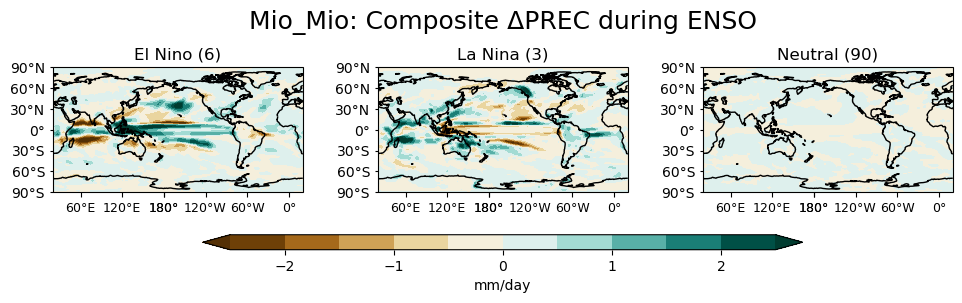

In [51]:
labels=['El Nino','La Nina', 'Neutral']
clevs = np.linspace(-2.5, 2.5, 11)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs_Mio = plt.subplots(nrows=1,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=200)},
                        figsize=(10, 15))

#flatten axs into a 1-D array (just 3 rows)
axs_Mio = axs_Mio.flatten()

#Loop over all of the composites and plot
for i,enso in enumerate(comp_precip_Mio):

        # Select the season
        data = comp_precip_Mio[i]

        # Add the cyclic point
        data,lons = add_cyclic_point(data, coord=comp_precip_Mio[i]['lon'])

        # Contour plot
        cs=axs_Mio[i].contourf(lons,comp_precip_Mio[i]['lat'],data,clevs,
                          transform = ccrs.PlateCarree(),
                          cmap='BrBG',extend='both')

       # Longitude labels
        axs_Mio[i].set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs_Mio[i].xaxis.set_major_formatter(lon_formatter)
        axs_Mio[i].tick_params(axis='y', size=2)             # set xtick parameters
        for xlabel in axs_Mio[i].get_xticklabels():          # set xticks_label
            xlabel.set_fontsize(9)     

        # Latitude labels
        axs_Mio[i].set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs_Mio[i].yaxis.set_major_formatter(lat_formatter)

        
        # Title each subplot with the name of the season
        axs_Mio[i].set_title(labels[i]+' ('+str(counts_Mio[i])+')')

        # Draw the coastines for each subplot
        axs_Mio[i].coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.65, left=0.05, right=0.95, wspace=0.3, hspace=0.1)

# Add a colorbar
cax  = fig.add_axes([0.2, 0.37, 0.6, 0.01])    # set the [x0, y0, width, height] of the colorbar
CB   = plt.colorbar(cs, cax = cax, orientation='horizontal', label='mm/day')

# Add a big title at the top
plt.suptitle('Mio_Mio: Composite ΔPREC during ENSO', y=0.53, fontsize=18) ;